### Exploratory Data Analysis

Purpose: To comprehend data with simple feature engineering.

Steps: 
1) Load and clean the data.
2) Join the data to produce one data frame.
3) Make basic feature enginnering:
    a) count basic metric per user
    b) use domain knowledge (to introduce more information)
    c) hot-encoding of categorical variables
    d) transform variables, if neccesary
4) Pair-plot numeric features.
5) Make seperatly raw and aggregated dataset (grouped by pair (user, song)).
6) Try to segment users.
7) Do dimensionality reduction.
8) Make an entrée model.
9) Export data.

Goals: 
     a) To clean and engineer the data so it can be understood by most ML/DL tools.
     b) To suggest on which features we should focus most.

### Import Packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from apyori import apriori
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Read data

In [2]:
filename = 'Data_InCarMusic.xlsx'

In [3]:
sheetname = 'ContextualRating'
contextual_rating = pd.read_excel(filename, sheet_name=sheetname)
print(f'Successfully read {len(contextual_rating):,} rows from the "{sheetname}" Excel sheet')
print(f'Columns found: {contextual_rating.columns.tolist()}')

Successfully read 4,012 rows from the "ContextualRating" Excel sheet
Columns found: ['UserID', 'ItemID', ' Rating', 'DrivingStyle', 'landscape', 'mood', 'naturalphenomena ', 'RoadType', 'sleepiness', 'trafficConditions', 'weather']


In [4]:
sheetname = 'Music Track'
music_track = pd.read_excel(filename, sheet_name=sheetname)
print(f'Successfully read {len(music_track):,} rows from the "{sheetname}" Excel sheet')
print(f'Columns found: {music_track.columns.tolist()}')

Successfully read 139 rows from the "Music Track" Excel sheet
Columns found: ['id', ' album', ' artist', ' title', ' mp3url', ' description', ' imageurl', ' category_id']


In [5]:
sheetname = 'Music Category'
music_category = pd.read_excel(filename, sheet_name=sheetname, header=None)
print(f'Successfully read {len(music_category):,} rows from the "{sheetname}" Excel sheet')
print(f'Columns found: {music_category.columns.tolist()} (temporary column names)')

Successfully read 10 rows from the "Music Category" Excel sheet
Columns found: [0, 1] (temporary column names)


## Data Cleaning

### Contextual Ratings

In [6]:
contextual_rating.columns.to_series().groupby(contextual_rating.dtypes).groups

{int64: ['UserID', 'ItemID', ' Rating'], object: ['DrivingStyle', 'landscape', 'mood', 'naturalphenomena ', 'RoadType', 'sleepiness', 'trafficConditions', 'weather']}

Most of the column are of 'string' type, except for ID columns like the "user id", "song id" and the song rating.

In [7]:
contextual_rating.dtypes

UserID                int64
ItemID                int64
 Rating               int64
DrivingStyle         object
landscape            object
mood                 object
naturalphenomena     object
RoadType             object
sleepiness           object
trafficConditions    object
weather              object
dtype: object

Column names have whitespace in them, let's remove them by using str.strip() method from the Python standard library.

In [8]:
contextual_rating.columns = [x.strip() for x in contextual_rating.columns.tolist()]

### Music Tracks

In [9]:
music_track.columns.to_series().groupby(music_track.dtypes).groups

{int64: ['id', ' category_id'], object: [' album', ' artist', ' title', ' mp3url', ' description', ' imageurl']}

Stripping whitespace,

In [10]:
music_track.columns = [x.strip() for x in music_track.columns.tolist()]

#### Example songs (first 5):

In [11]:
music_track.head()

,id,album,artist,title,mp3url,description,imageurl,category_id
0,248,\N,B.B.King,The Thrill is Gone,Music/Blues/B.B.King - The Thrill is Gone.mp3,\N,img/music.jpg,1
1,250,\N,Mamie Smith,Crazy Blues,Music/Blues/Mamie Smith - Crazy Blues.mp3,\N,img/music.jpg,1
2,251,\N,Robert Johnson,Hellhound On My Trail,Music/Blues/Robert Johnson - Hellhound On My T...,\N,img/music.jpg,1
3,252,\N,T-Bone Walker,Stormy Monday,Music/Blues/T-Bone Walker - Stormy Monday.mp3,\N,img/music.jpg,1
4,253,\N,Antonio Vivaldi,Four Seasons,Music/Classical/Antonio Vivaldi - Four Seasons...,\N,img/music.jpg,2


Some columns don't have valuable information. For example, description attribute is always empty, and the reference to album cover is invalid. Name of the MP3 file doesn't hold any information as well.

In [12]:
music_track = music_track[['id', 'artist', 'title', 'category_id']].rename(columns={'id': 'ItemID'})

In [13]:
music_track.dtypes

ItemID          int64
artist         object
title          object
category_id     int64
dtype: object

# TODO: use Levenshtein distance to check for possible duplicates.

#### Most Common Artists

In [14]:
most_common_artist = music_track.groupby('artist')['artist'].count()
most_common_artist.sort_values(ascending=False).head(12)

artist
Lady GaGa          4
Unheilig           4
Rihanna            3
Black Eyed Peas    3
Ich + Ich          3
Timbaland          3
Jason Derulo       2
Jan Delay          2
OneRepublic        2
Culcha Candela     2
Bob Marley         2
Jay-Z              2
Name: artist, dtype: int64

### Music Category

In [15]:
music_category.columns = ['category_id', 'category name']

In [16]:
music_category.dtypes

category_id       int64
category name    object
dtype: object

## Feature Engineering

### Print Example Rows

In [17]:
contextual_rating.iloc[3].to_dict()

{'UserID': 1001,
 'ItemID': 259,
 'Rating': 4,
 'DrivingStyle': nan,
 'landscape': nan,
 'mood': nan,
 'naturalphenomena': nan,
 'RoadType': nan,
 'sleepiness': nan,
 'trafficConditions': nan,
 'weather': 'snowing'}

In [18]:
music_track.iloc[10].to_dict()

{'ItemID': 259,
 'artist': 'Hank Williams',
 'title': 'Im So Lonesome I Could Cry',
 'category_id': 3}

### Join Tables

#### Enrich main dataframe with information on the song:

In [19]:
data = contextual_rating.merge(music_track, suffixes=('_ctx', '_track'), on='ItemID', how='inner')

In [20]:
if len(data) == len(contextual_rating):
    print(f'Success! Every music track is findable in the "music_track" dataframe!')
else:
    raise AssertionError("Some tracks are missing.")

Success! Every music track is findable in the "music_track" dataframe!


#### Add information about the category of the song:

In [21]:
data = data.merge(music_category, on='category_id', how='inner')

In [22]:
if len(data) == len(contextual_rating):
    print(f'Success! Every music track has a proper music category assigned.')
else:
    raise AssertionError("Some categories are missing.")

Success! Every music track has a proper music category assigned.


### Characterize users by their activity:

#### Count number of items user listened to a song:

In [23]:
counts = data.groupby('UserID')['UserID'].count()

In [24]:
data['number_of_songs'] = data.apply(lambda x: counts[x.UserID], axis=1)

<AxesSubplot:>

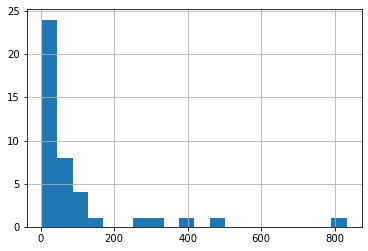

In [25]:
counts.hist(bins=20)

#### Count nuMber of unique songs user listened to:

In [26]:
counts = data.groupby(['UserID', ])['ItemID'].nunique()

In [27]:
data['number_of_unique_songs'] = data.apply(lambda x: counts[x.UserID], axis=1)

<AxesSubplot:>

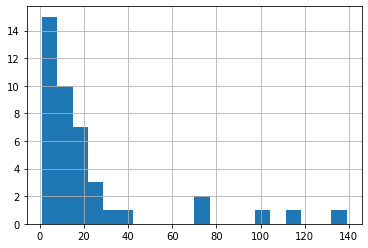

In [28]:
counts.hist(bins=20)

#### Count number of unique music genres:

In [29]:
counts = data.groupby(['UserID', ])['category_id'].nunique()

In [30]:
data['number_of_unique_genres'] = data.apply(lambda x: counts[x.UserID], axis=1)

<AxesSubplot:>

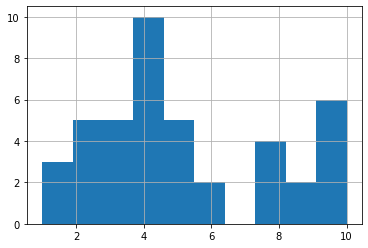

In [31]:
counts.hist(bins=10)

#### Count dominance ratio of the user's most popular genre:

In [32]:
counts = data.groupby(['UserID', 'category name'])['category name'].count()

genre_counts = counts.groupby(level=0).apply(lambda x: x / float(x.sum()))

In [33]:
def second_dominant(c):
    d, _max = {}, c.max()
    for item in c.items():
        e, v = item[0], item[1]
        if v in d:
            d[v] += ', ' + e
        else:
            d[v] = e
    del d[_max]
    try:
        return d[max(list(d.keys()))]
    except ValueError:
        return None

In [34]:
data['dominant_genre'] = data.apply(lambda x: genre_counts[x['UserID']].idxmax(), axis=1)

In [35]:
data['second_dominant_genre'] = data.apply(lambda x: second_dominant(genre_counts[x['UserID']]), axis=1)

In [36]:
data['genre_ratio'] = data.apply(lambda x: genre_counts[x['UserID']][x['category name']], axis=1)

<AxesSubplot:>

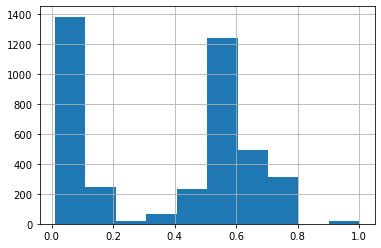

In [37]:
data['genre_ratio'].hist()

In [38]:
# assign ratio of the most dominant music genre
data['main_genre_dominance'] = data.apply(lambda x: genre_counts[x['UserID']].max(), axis=1)

<AxesSubplot:>

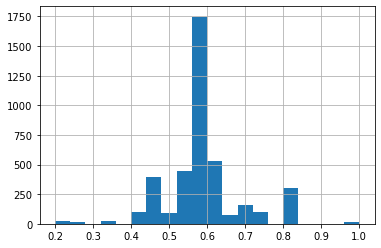

In [39]:
data['main_genre_dominance'].hist(bins=20)

#### Music Preference ("taste"):

#### Sensorial Stimulus vs Choice of Music:

In [40]:
calm_conditions = {'landscape': ['country side', ],
                   'mood': ['lazy', ],
                   'driving style': ['relaxed driving', ],
                   'natural phenomena': ['afternoon', 'night'],
                   'sleepiness': ['sleepy', ],
                   'traffic conditions': ['free road', ],
                   'weather': ['cloudy', ]}

def score_calm_conditions(row):
    points = 0.0
    if (row['landscape'] is not None) and (row['landscape'] in calm_conditions['landscape']):
        points += 1.0
    if (row['mood'] is not None) and (row['mood'] in calm_conditions['mood']):
        points += 1.0
    if (row['DrivingStyle'] is not None) and (row['DrivingStyle'] in calm_conditions['driving style']):
        points += 1.0
    if (row['naturalphenomena'] is not None) and (row['naturalphenomena'] in calm_conditions['natural phenomena']):
        points += 1.0
    if (row['sleepiness'] is not None) and (row['sleepiness'] in calm_conditions['sleepiness']):
        points += 1.0
    if (row['trafficConditions'] is not None) and (row['trafficConditions'] in calm_conditions['traffic conditions']):
        points += 1.0
    if (row['weather'] is not None) and (row['weather'] in calm_conditions['weather']):
        points += 1.0
    return points

stimulation_conditions = {'landscape': ['mountains/hills', ],
                          'mood': ['active', ],
                          'driving style': ['sport driving', ],
                          'natural phenomena': ['day time', 'morning'],
                          'sleepiness': ['awake', ],
                          'traffic conditions': ['lots of cars', 'traffic jam', ],
                          'weather': ['rainy', 'snowing', ]}

def score_stimulative_conditions(row):
    points = 0.0
    if (row['landscape'] is not None) and (row['landscape'] in stimulation_conditions['landscape']):
        points += 1.0
    if (row['mood'] is not None) and (row['mood'] in stimulation_conditions['mood']):
        points += 1.0
    if (row['DrivingStyle'] is not None) and (row['DrivingStyle'] in stimulation_conditions['driving style']):
        points += 1.0
    if (row['naturalphenomena'] is not None) and (row['naturalphenomena'] in stimulation_conditions['natural phenomena']):
        points += 1.0
    if (row['sleepiness'] is not None) and (row['sleepiness'] in stimulation_conditions['sleepiness']):
        points += 1.0
    if (row['trafficConditions'] is not None) and (row['trafficConditions'] in stimulation_conditions['traffic conditions']):
        points += 1.0
    if (row['weather'] is not None) and (row['weather'] in stimulation_conditions['weather']):
        points += 1.0
    return points

In [41]:
data['no_stimulus_points'] = data.apply(lambda x: score_calm_conditions(x), axis=1)
data['stimulus_points'] = data.apply(lambda x: score_stimulative_conditions(x), axis=1)

#### Remove Duplicated Columns

In [42]:
data.drop('category_id', axis=1, inplace=True)

## Data Book

In [43]:
data.columns

Index(['UserID', 'ItemID', 'Rating', 'DrivingStyle', 'landscape', 'mood',
       'naturalphenomena', 'RoadType', 'sleepiness', 'trafficConditions',
       'weather', 'artist', 'title', 'category name', 'number_of_songs',
       'number_of_unique_songs', 'number_of_unique_genres', 'dominant_genre',
       'second_dominant_genre', 'genre_ratio', 'main_genre_dominance',
       'no_stimulus_points', 'stimulus_points'],
      dtype='object')

**UserID** - ID which uniquely identifies a person driving & listening to track

**ItemID** - track ID which uniquely identifies a song

**Rating** - a 5-star rating given to a track

**DrivingStyle** - what the style of driving (while actually listening to the song)?

Answers questions: a) *Are you driving in a relaxed mood?* b) *Is your driving style is very sportive?*

**landscape** - what type of landscape is behind window?

Answers questions: a) *Are you driving along a coast line?* b) *Are you on a country side?* 
c) *Are you driving between mountains or hills?* d) *Are you driving in a city?*

**mood** - current mood of the driver

Answers questions: a) *Are you feeling very active?* b) *Are you happy?* c) *Are you lazy now?* d) *Do you feel sad?*

**naturalphenomena** - what time of a day is it

Answers questions: a) *Is it afternoon?* b) *Is it day time?* c) *Is it is morning?* d) *Are you driving at night?* 

**RoadType** - what type of road the driver is currently traveling through

Answers questions: a) Are you driving in a city street? b) Are you driving on a highway? c) Are you driving through serpentine curves?

## Pair plot

In [44]:
columns_of_interest = ['Rating', 'number_of_songs', 'stimulus_points', 'main_genre_dominance',
                       'number_of_unique_songs', 'number_of_unique_genres', 'category name']

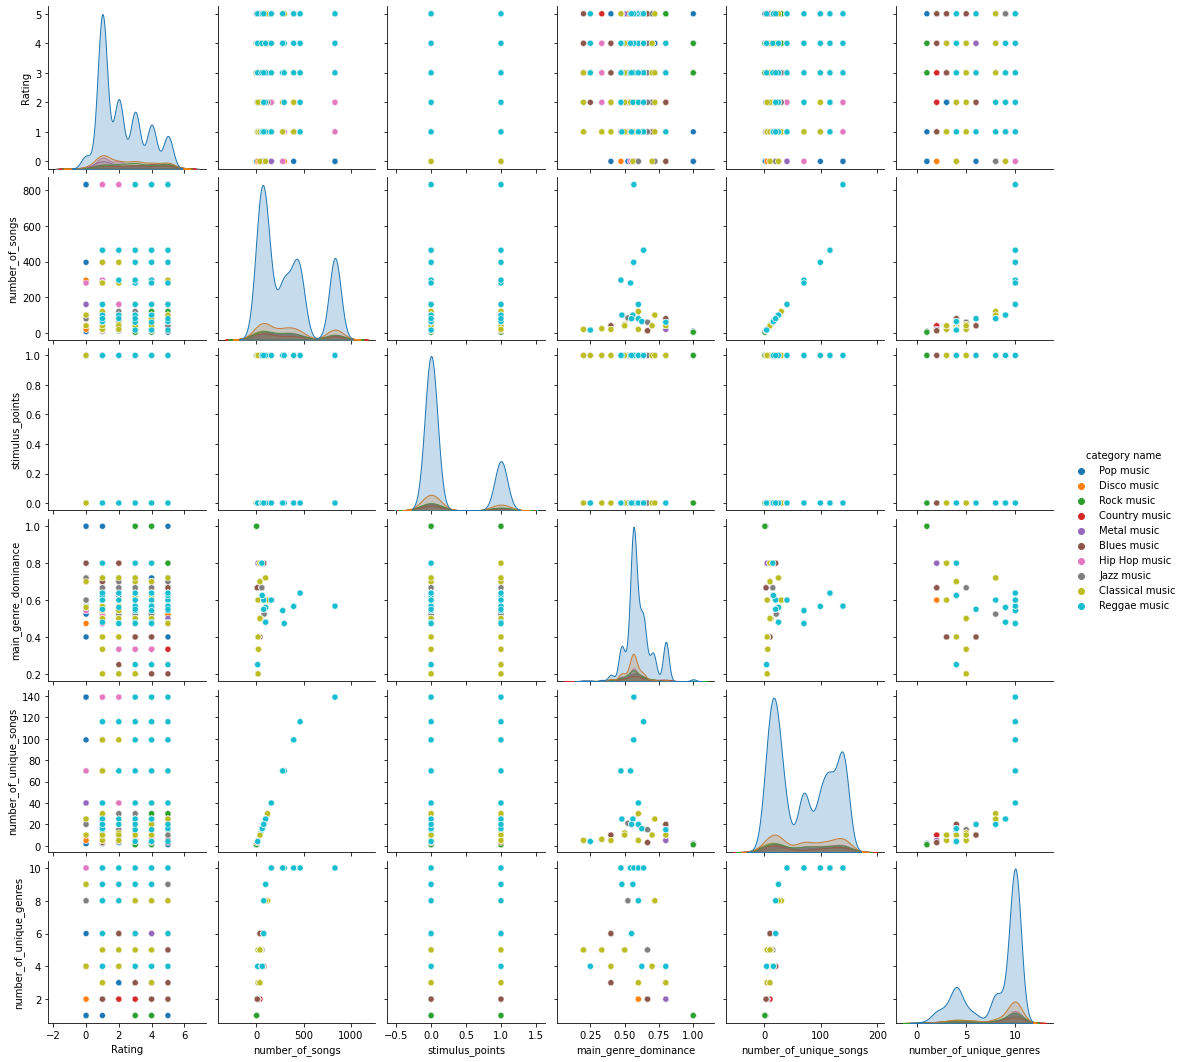

In [45]:
import seaborn as sns
sns.pairplot(data=data[columns_of_interest], hue="category name", dropna=True)

## One-hot Encoding of Categorical Variables:

In [46]:
data.columns

Index(['UserID', 'ItemID', 'Rating', 'DrivingStyle', 'landscape', 'mood',
       'naturalphenomena', 'RoadType', 'sleepiness', 'trafficConditions',
       'weather', 'artist', 'title', 'category name', 'number_of_songs',
       'number_of_unique_songs', 'number_of_unique_genres', 'dominant_genre',
       'second_dominant_genre', 'genre_ratio', 'main_genre_dominance',
       'no_stimulus_points', 'stimulus_points'],
      dtype='object')

In [47]:
data_encoded = pd.get_dummies(data.drop(['artist', 'title'], axis=1))

In [48]:
';  '.join(data_encoded.columns.tolist())

'UserID;  ItemID;  Rating;  number_of_songs;  number_of_unique_songs;  number_of_unique_genres;  genre_ratio;  main_genre_dominance;  no_stimulus_points;  stimulus_points;  DrivingStyle_relaxed driving;  DrivingStyle_sport driving;  landscape_coast line;  landscape_country side;  landscape_mountains;  landscape_urban;  mood_active;  mood_happy;  mood_lazy;  mood_sad;  naturalphenomena_afternoon;  naturalphenomena_day time;  naturalphenomena_morning;  naturalphenomena_night;  RoadType_city;  RoadType_highway;  RoadType_serpentine;  sleepiness_awake;  sleepiness_sleepy;  trafficConditions_free road;  trafficConditions_lots of cars;  trafficConditions_traffic jam;  weather_cloudy;  weather_rainy;  weather_snowing;  weather_sunny;  category name_Blues music;  category name_Classical music;  category name_Country music;  category name_Disco music;  category name_Hip Hop music;  category name_Jazz music;  category name_Metal music;  category name_Pop music;  category name_Reggae music;  cate

## Aggregating Data - Alternative Set

In [50]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=3a8b6e8c3bebb754587d430d0a9dd9abc3874bf770f5b9c0b10559d4bf22a131
  Stored in directory: c:\users\ria\appdata\local\pip\cache\wheels\63\e8\ec\75b1df467ecf57b6ececb32cb16f4e86697cbfe55cb0c51f07
Successfully built pandasql


In [51]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
data_aggr = pysqldf('''select UserID, ItemID, avg(Rating) as avg_rating,
                       avg(number_of_unique_songs) as number_of_unique_songs,
                       avg(number_of_unique_genres) as number_of_unique_genres,
                       avg(genre_ratio) as genre_ratio,
                       avg(main_genre_dominance) as main_genre_dominance,
                       sum(no_stimulus_points) as no_stimulus_points,
                       sum(stimulus_points) as stimulus_points,
                       sum(`DrivingStyle_relaxed driving`) as driving_style_relaxed_driving,  
                       sum(`DrivingStyle_sport driving`) as driving_style_sport_driving,  
                       sum(`landscape_coast line`) as landscape_coast_line,
                       sum(`landscape_country side`) as landscape_country_side,
                       sum(landscape_mountains) as landscape_mountains,  
                       sum(landscape_urban) as landscape_urban,
                       sum(mood_active) as mood_active,
                       sum(mood_happy) as mood_happy,
                       sum(mood_lazy) as mood_lazy,
                       sum(mood_sad) as mood_sad,
                       sum(naturalphenomena_afternoon) as natural_phenomena_afternoon,
                       sum(`naturalphenomena_day time`) as natural_phenomena_day_time,
                       sum(naturalphenomena_morning) as natural_phenomena_morning,
                       sum(naturalphenomena_night) as natural_phenomena_night,
                       sum(RoadType_city) as road_type_city,
                       sum(RoadType_highway) as road_type_highway,
                       sum(RoadType_serpentine) as road_type_serpentine,
                       sum(sleepiness_awake) as sleepiness_awake,
                       sum(sleepiness_sleepy) as sleepiness_sleepy,
                       sum(`trafficConditions_free road`) as traffic_conditions_free_road,
                       sum(`trafficConditions_lots of cars`) as traffic_conditions_lots_of_cars,
                       sum(`trafficConditions_traffic jam`) as traffic_conditions_traffic_jam,
                       sum(weather_cloudy) as weather_cloudy,
                       sum(weather_rainy) as weather_rainy,
                       sum(weather_snowing) as weather_snowing,
                       sum(weather_sunny) as weather_sunny,
                       avg(`category name_Blues music`) as category_name_blues,
                       avg(`category name_Classical music`) as category_name_classical,
                       avg(`category name_Country music`) as category_name_country,
                       avg(`category name_Disco music`) as category_name_disco,
                       avg(`category name_Hip Hop music`) as category_name_hip_hop,
                       avg(`category name_Jazz music`) as category_name_jazz,
                       avg(`category name_Metal music`) as category_name_metal,
                       avg(`category name_Pop music`) as category_name_pop,
                       avg(`category name_Reggae music`) as category_name_reggae,
                       avg(`category name_Rock music`) as category_name_rock, 
                       avg(`dominant_genre_Blues music`) as dominant_genre_blues,
                       avg(`dominant_genre_Pop music`) as dominant_genre_pop,
                       avg(`dominant_genre_Rock music`) as dominant_genre_rock,
                       avg(`second_dominant_genre_Blues music`) as second_dominant_blues,
                       avg(`second_dominant_genre_Blues music, Classical music, Disco music`) as second_dominant_blues_classical_disco,
                       avg(`second_dominant_genre_Blues music, Classical music, Hip Hop music`) as second_dominant_blues_classicalsecond_dominant_hh,
                       avg(`second_dominant_genre_Blues music, Disco music, Rock music`) as second_dominant_blues_disco_rock,
                       avg(`second_dominant_genre_Blues music, Hip Hop music`) as second_dominant_blues_hh,
                       avg(`second_dominant_genre_Blues music, Metal music, Reggae music`) as second_dominant_blues_metal_reggae,
                       avg(`second_dominant_genre_Classical music`) as second_dominant_classical,
                       avg(`second_dominant_genre_Classical music, Country music`) as second_dominant_classical_country,
                       avg(`second_dominant_genre_Classical music, Country music, Disco music, Hip Hop music`) as second_dominant_classical_country_disco_hh,
                       avg(`second_dominant_genre_Classical music, Country music, Disco music, Hip Hop music, Jazz music, Metal music, Rock music`) as second_dominant_classical_country_disco_hh_jazz_metal_rock,
                       avg(`second_dominant_genre_Classical music, Disco music`) as second_dominant_classical_disco,
                       avg(`second_dominant_genre_Classical music, Disco music, Reggae music`) as second_dominant_classical_disco_reggae,
                       avg(`second_dominant_genre_Classical music, Hip Hop music, Rock music`) as second_dominant_classical_hh_rock,
                       avg(`second_dominant_genre_Country music`) as second_dominant_country,
                       avg(`second_dominant_genre_Country music, Disco music, Rock music`) as second_dominant_country_disco_rock,
                       avg(`second_dominant_genre_Country music, Jazz music, Rock music`) as second_dominant_country_jazz_rock,
                       avg(`second_dominant_genre_Disco music`) as second_dominant_disco,
                       avg(`second_dominant_genre_Disco music, Hip Hop music`) as second_dominant_disco_hh,
                       avg(`second_dominant_genre_Jazz music`) as second_dominant_jazz,
                       avg(`second_dominant_genre_Metal music`) as second_dominant_metal
                       from data_encoded
                       group by UserID, ItemID;''')

In [52]:
data_aggr.describe()

,UserID,ItemID,avg_rating,number_of_unique_songs,number_of_unique_genres,genre_ratio,main_genre_dominance,no_stimulus_points,stimulus_points,driving_style_relaxed_driving,...,second_dominant_classical_disco,second_dominant_classical_disco_reggae,second_dominant_classical_hh_rock,second_dominant_country,second_dominant_country_disco_rock,second_dominant_country_jazz_rock,second_dominant_disco,second_dominant_disco_hh,second_dominant_jazz,second_dominant_metal
count,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,...,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,1019.140860,557.454839,2.373441,64.984946,8.132258,0.394187,0.589208,0.986022,1.088172,0.194624,...,0.016129,0.016129,0.005376,0.016129,0.010753,0.010753,0.682796,0.012903,0.016129,0.005376
std,11.322104,216.087419,1.275900,48.325411,2.641218,0.271515,0.102080,0.868550,0.862301,0.404194,...,0.126040,0.126040,0.073166,0.126040,0.103192,0.103192,0.465638,0.112918,0.126040,0.073166
min,1001.000000,248.000000,0.000000,1.000000,1.000000,0.010101,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1009.000000,281.000000,1.000000,20.000000,6.000000,0.080000,0.542857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1019.000000,692.000000,2.250000,70.000000,10.000000,0.542857,0.567308,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1031.750000,729.750000,3.250000,116.000000,10.000000,0.600000,0.637931,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1042.000000,762.000000,5.000000,139.000000,10.000000,1.000000,1.000000,5.000000,5.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Profile All Data:

### Un-aggregated Data:

In [55]:
!pip install --upgrade --force-reinstall llvmlite

  Using cached llvmlite-0.42.0-cp39-cp39-win_amd64.whl (28.1 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
report = data.profile_report(style={'full_width':True})

In [ ]:
report

In [ ]:
f'Rejected variables due to high correlation with some other variables: {report.get_rejected_variables()}'

"Rejected variables due to high correlation with some other variables: ['number_of_unique_songs']"

### Aggregated Data:

In [ ]:
report_aggr = data_aggr.profile_report(style={'full_width':True})

In [ ]:
f'Rejected variables due to high correlation with some other variables: {report_aggr.get_rejected_variables()}'

"Rejected variables due to high correlation with some other variables: ['genre_ratio']"

## Dimensionality Reduction:

### Explaining Variance:

In [65]:
comp_analysis = pd.DataFrame()

data_for_pca = data_aggr.drop(['UserID', 'ItemID', 'genre_ratio'], axis=1)

pca = PCA(n_components=3)  # n_components - number of components to keep
pca_result = pca.fit_transform(data_for_pca.values)

comp_analysis['pca-one'] = pca_result[:,0]
comp_analysis['pca-two'] = pca_result[:,1]
comp_analysis['pca-three'] = pca_result[:,2]

variance = pca.explained_variance_ratio_
print(f'Explained variance: {variance}')

sv = pca.singular_values_
print(f'Singular values: {variance}')

Explained variance: [9.95765277e-01 1.25955271e-03 6.93512217e-04]
Singular values: [9.95765277e-01 1.25955271e-03 6.93512217e-04]


In [66]:
pcv = pca.explained_variance_ratio_
'Total explained variance by {} components is equal to {}'.format(len(pcv), sum(pcv))

'Total explained variance by 3 components is equal to 0.9977183419073326'

### Minimization of Relative Entropy:

T-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get *different results*.

**n_components** - dimension of the embedded space.

**perplexity** - is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity.

**early_exaggeration** - controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space.

In [64]:
tsne_input = data_aggr.drop(['UserID', 'ItemID', 'genre_ratio'], axis=1)

tsne = TSNE(n_components=3, 
            verbose=1, random_state=42, 
            perplexity=28.0, 
            early_exaggeration=12.0,
            n_iter=500)
tsne_results = tsne.fit_transform(tsne_input.values)

c:\Users\Ria\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  "n_components": [Interval(Integral, 1, None, closed="left")],
c:\Users\Ria\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  "metric": [StrOptions(set(_VALID_METRICS) | {"precomputed"}), callable],


[t-SNE] Computing 85 nearest neighbors...
[t-SNE] Indexed 930 samples in 0.001s...
[t-SNE] Computed neighbors for 930 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 930 / 930
[t-SNE] Mean sigma: 1.359837
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.081867
[t-SNE] KL divergence after 500 iterations: 0.389593


In [68]:
df_tsne = pd.DataFrame()

df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['z-tsne'] = tsne_results[:,2]

In [69]:
# filter out anomalies
df_tsne = df_tsne[df_tsne['z-tsne'] < 1]

## Association Rule Learning (Apriori)

Association rule mining is a technique to identify underlying relations between different items. Normally, it is used to predict which items will be bought together. Take an example of a super market, where customers can buy variety of items. Usually, there is a pattern in what the customers buy. We can apply similar technique to predict which songs will be listened to together during a single drive. 

In [70]:
songs = []

t_grouped = data_aggr.groupby(['UserID', ])

for group_name, group in t_grouped:
    items = []
    for row_index, row in group.iterrows():
        items.append(music_track[music_track.ItemID == row['ItemID']].iloc[0].title)
    songs.append(items)

There are three major components of Apriori algorithm:

    Support
    Confidence
    Lift


In [71]:
results = apriori(songs, min_confidence=0.75, min_lift=5, min_length=2)

The minimum lift of "5" tells us that right element is 5.0 times more likely to be bought by the customers who buy left element compared to the default likelihood of the sale of right element.

In [72]:
apriori_results = itertools.islice(results, 5)

### Example Results (rules):

In [73]:
association_rules = list(apriori_results)

for item in association_rules:
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: Neopolitan Dreams -> Alles kann besser werde
Support: 0.11904761904761904
Confidence: 0.8333333333333334
Lift: 5.000000000000001
Rule: Alles kann besser werde -> Secrets
Support: 0.11904761904761904
Confidence: 0.8333333333333334
Lift: 5.000000000000001
Rule: Alles wird gut - Album Version -> I Can't Quit You Baby
Support: 0.11904761904761904
Confidence: 0.8333333333333334
Lift: 5.000000000000001
Rule: Bad Romance -> Hypnotize
Support: 0.11904761904761904
Confidence: 0.8333333333333334
Lift: 5.000000000000001
Rule: Pursuit Of Vikings -> Bad Romance
Support: 0.14285714285714285
Confidence: 0.8571428571428571
Lift: 5.142857142857143


## Export Data to File:

Saving hot-encoded, context aware dataset to a comma-separated file, which can be later read by pandas in different notebook.

In [74]:
data_encoded.to_csv('dataset.csv', sep=",", index=False, header=True)

Saving hot-encoded, aggregated dataset to a comma-separated file.

In [75]:
data_aggr.to_csv('dataset_aggr.csv', sep=",", index=False, header=True)

### Pickle File:

We're pickling whole datasets to a binary pickle file.

In [76]:
pickle.dump(data_encoded, file=open("dataset.pickle", 'wb'))
pickle.dump(data_aggr, file=open("dataset_aggr.pickle", 'wb'))